<a href="https://colab.research.google.com/github/4nchez/Colab-Jupiter/blob/master/%EC%97%B0%EA%B5%AC%EC%8B%A4_%EA%B8%B0%EB%B3%B8%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Challenge : Dogs-vs-Cats - Binary Image Classification using Keras
해당 포스트는 [Kaggle  Dogs-vs-Cats challenge](https://www.kaggle.com/c/dogs-vs-cats) 해결하기위해 만들었으며, 여러 가지 자료들을 참고하여 만든 포스트 입니다. [이분을 많이 참조..](https://github.com/mjbhobe/dl-articles-medium)


*   개발 환경 : google colab, Python3, Tensorflow, Keras
*   실험 모델 : VGG16(Transfer Learning)
*   실험에 쓰인 데이터 : Kaggle Dogs vs Cats challenge
*   Test {개: 1,000, 고양이: 1,000} (총 2,000개)
*   Training {개: 5,000, 고양이: 5,000} (총 10,000개)
*   Validation {개: 2,500, 고양이: 2,500} (총 5,000개)
*   IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

참고 사항
* Google Colab에서이 노트북을 실행할 때 아래 셀에`USE_COLAB = True`를 설정하고 그렇지 않으면`USE_COLAB = False`를 설정하세요.
*`USE_COLAB = True`는 현재 사용자의 로그인을 위해 Google 드라이브에 대한 액세스를 설정합니다 (Google ID가 있다고 가정).
    * Google 드라이브는 '/ content / drive / 내 드라이브'에 매핑되고 노트북은 Google 드라이브의 '/ content / drive / My Drive / Colab Notebooks /'폴더에 저장됩니다.
    * 코드는`/ content / drive / My Drive / Colab Notebooks /`폴더를`system.path`에 추가합니다. 커스텀 Python 코드 파일`(* .py)`를 여기에 저장하면`system.path`에 자동으로 추가되고 노트북에서 사용할 수 있습니다. *
*`MODEL_STATES` 전역 변수는 모델의 상태 (즉, 훈련 된 가중치 및 편향)가`.h5` 파일에 저장되는 _correct_ 폴더를 가리 키도록 생성됩니다.
    *`USE_COLAB = True` 인 경우`MODEL_STATES`는 Google Drive의`/ content / drive / My Drive / Colab Notebooks / model_states` 폴더에 매핑됩니다.
    * 그렇지 않으면`MODEL_STATES`는 로컬 디스크의`. / model_states` 폴더 (예 : 노트북이 저장된 폴더의 하위 폴더)에 매핑됩니다.

In [1]:
from google.colab import files
src = list(files.upload().values())[0]

Saving kr_helper_funcs.py to kr_helper_funcs.py


구글 드라이브 연동 코드

In [2]:
USE_COLAB = True
 
import os
 
#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    from google.colab import drive
 
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    colab_notebooks_path = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(colab_notebooks_path):
        print('You Colab notebooks are available at ', colab_notebooks_path)
    
        #!ls '/content/drive/My Drive/Colab Notebooks/'
 
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(colab_notebooks_path)
        print('NOTE: {} is appended to sys.path!'.format(colab_notebooks_path))
        # import kr_helper_funcs as kru
        MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states" #실험에 쓴 모델을 저장할 드라이브 경로
        IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs" #구글 드라이브에 저장되어 있는 데이터셋
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    IMAGES_ZIP_DIR = "./images/kaggle/cats_vs_dogs"
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/
NOTE: /content/drive/My Drive/Colab Notebooks/ is appended to sys.path!


## Kaggle  Dogs-vs-Cats challenge Dataset
Kaggle train.zip 에는 개와 고양이의 이미지 25,000 개 (고양이 색상 이미지 12,500 개 및 다양한 크기의 개 색상 이미지 12,500 개)가 포함되어 있습니다.

train Data 중 별도의 프로그램을 사용하여 고양이와 개에 개에 각각 5,000개의 훈련 이미지, 고양이와 개에 대한 2,500개의 평가 이미지, 고양이와 개에 개에 각각 1,000개의 테스트 이미지로 구성된 작은 데이터 세트를 만들었습니다. 그런 다음 이미지 Dataset.zip 파일을 Google 드라이브에 업로드했습니다.

zip 파일 cats_vs_dogs_images_small.zip은 내 Google 드라이브의 IMAGES_ZIP_DIR에서 사용할 수 있습니다. 아래 코드 셀은 로컬로 다운로드하고 /tmp 폴더에 이미지 압축을 풉니다.

In [3]:
import sys, os, random
import numpy as np
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
 
import kr_helper_funcs as kru
 
plt.style.use('seaborn')
 
seed = 123
random.seed(seed)
np.random.seed(seed)
# tf.set_random_seed(seed)
 
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

Using Tensorflow version  2.3.0


In [4]:
import os, shutil
import zipfile
 
#!cp $(IMAGES_ZIP_DIR/images_small.zip" /tmp
source_file = os.path.join(IMAGES_ZIP_DIR, 'cats_vs_dogs_images_small.zip')
local_zip = '/tmp/cats_vs_dogs_images_small.zip'
 
print("Copying from drive %s to %s..." % (source_file, local_zip), flush=True)
shutil.copyfile(source_file, local_zip)
 
assert os.path.exists(local_zip)
 
print('Extracting all images...', flush=True)
zip_ref = zipfile.ZipFile(local_zip, 'r')
 
zip_ref.extractall('/tmp')
zip_ref.close()

Copying from drive /content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs/cats_vs_dogs_images_small.zip to /tmp/cats_vs_dogs_images_small.zip...
Extracting all images...


## 실험에 쓰일 데이터 파일 연결

In [5]:
images_root = "/tmp" # /content/drive/My Drive/img
assert os.path.exists(images_root), "%s folder does not exist!" % images_root
 
train_root = os.path.join(images_root,'training')
train_root_cat = os.path.join(train_root,'cat')
train_root_dog = os.path.join(train_root,'dog')
 
eval_root = os.path.join(images_root,'validation')
eval_root_cat = os.path.join(eval_root,'cat')
eval_root_dog = os.path.join(eval_root,'dog')
 
test_root = os.path.join(images_root,'test')
test_root_cat = os.path.join(test_root,'cat')
test_root_dog = os.path.join(test_root,'dog')

In [6]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kr_helper_funcs as kru

In [7]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

### pre-trained model VGG16

pre-trained 된 VGG16 모델을 사용합니다. VGG16모델의 끝부분인 FC 부분은 자르고 challenge에 맞게 다시 설정했습니다.


In [8]:
from tensorflow.keras.applications import VGG16
 
# NOTE: will download the weights for imagenet
vgg_base = VGG16(weights='imagenet',    # ImageNet 가중치 사용
                 include_top=False,     # Dense layers 사용 안함
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg_base.summary())

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [45]:
def build_model_xfer():
    from tensorflow.keras.optimizers import Adam
    
    #tf.keras.backend.clear_session()  # reset graph etc.
    
    model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    vgg_base.trainable = False
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [10]:
model_xfer = build_model_xfer()
print(model_xfer.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

**그리하여 총 23,629,633개의 파라미터를 가진 모델을 생성했습니다. 그러나 그중 학습후 가중치가 갱신되는 파라미터는 8,914,945(직접만든 FC)입니다. 컨볼루션층은 기존의 학습된 가중치를 사용합니다.**

In [46]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
 
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

In [13]:
hist = model_xfer.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
312/312 [==============================] - 45s 144ms/step - loss: 0.3643 - acc: 0.8345 - val_loss: 0.2607 - val_acc: 0.8848
Epoch 2/50
312/312 [==============================] - 44s 143ms/step - loss: 0.2783 - acc: 0.8791 - val_loss: 0.2420 - val_acc: 0.8952
Epoch 3/50
312/312 [==============================] - 44s 142ms/step - loss: 0.2471 - acc: 0.8933 - val_loss: 0.2281 - val_acc: 0.9022
Epoch 4/50
312/312 [==============================] - 45s 143ms/step - loss: 0.2358 - acc: 0.9004 - val_loss: 0.2346 - val_acc: 0.9016
Epoch 5/50
312/312 [==============================] - 44s 142ms/step - loss: 0.2261 - acc: 0.9035 - val_loss: 0.2292 - val_acc: 0.9054
Epoch 6/50
312/312 [==============================] - 44s 142ms/step - loss: 0.2173 - acc: 0.9070 - val_loss: 0.2258 - val_acc: 0.9048
Epoch 7/50
312/312 [==============================] - 44s 141ms/step - loss: 0.2010 - acc: 0.9150 - val_loss: 0.23

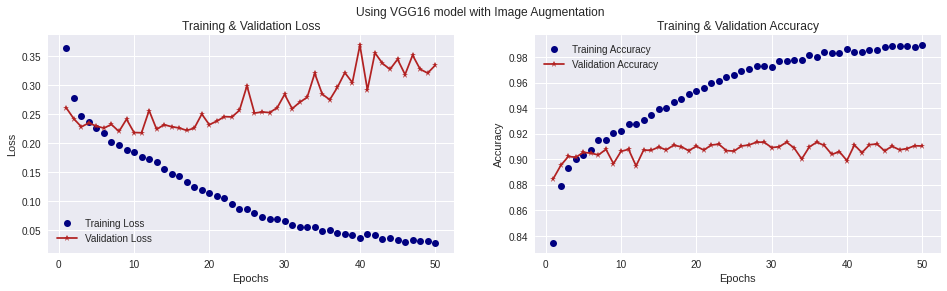

In [14]:
kru.show_plots(hist.history, plot_title='Using VGG16 model with Image Augmentation')

In [15]:
# 성능 평가
loss, acc = model_xfer.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
312/312 [==============================] - 30s 97ms/step - loss: 0.0026 - acc: 1.0000
Training data  -> loss: 0.003, acc: 1.000
156/156 [==============================] - 15s 97ms/step - loss: 0.3341 - acc: 0.9105
Cross-val data -> loss: 0.334, acc: 0.910
62/62 [==============================] - 6s 103ms/step - loss: 0.3579 - acc: 0.9017
Testing data   -> loss: 0.358, acc: 0.902
